In [1]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE
import seaborn as sns
from typing import Literal

In [2]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i + 1], t2s[met_i - 1:met_i + 1], M_0s[met_i - 1:met_i + 1]
spins_phi = np.zeros_like(M_0s)
ws[0] = ws[1]
t2s[0] = t2s[1]
M_0s[0] = M_0s[1]

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


In [3]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

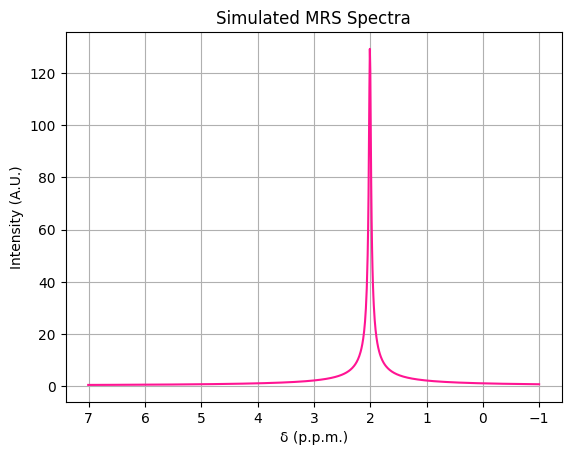

In [4]:
pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [5]:
L = 0.4
noise_threshold = 1e-30
rcond=noise_threshold
L_ = int(L*sig.size)

In [6]:
size = 20
# offsets = 10**(-(np.linspace(-3, size - 3 - 1, size)))
offsets = np.array([100.0, 10.0, 7.5, 5.0, 2.5, 1.0, 0.75, 0.5, 0.25, 0.1])
print(offsets)

offset = 10.0

sample_snrs = np.array([0.25, 0.50, 0.75, 1.0, 2.5, 5.0, 10.0, 25.0, 50.0, 75.0, 100.0])


[100.    10.     7.5    5.     2.5    1.     0.75   0.5    0.25   0.1 ]


In [10]:
L_ = int(L*2048)
shape = (sample_snrs.size, offsets.size, L_)
s0s_, phis_, omegas_, t2s_ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)
original_c_sigs = np.zeros((sample_snrs.size, offsets.size, 2048), dtype=np.complex128)

In [11]:
rerun = True
filename_end = "_offsets"
folder_name = "files/"
subfolder_name = "two_peaks_noisy/"

In [13]:
if rerun == True:
    for j in range(offsets.size):
        for i in range(sample_snrs.size):
            ws[1] = ws[0] + offsets[j]
            pop = pymri.population(ws, t2s, M_0s, spins_phi)

            sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
            freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
            sig_fft = sig_fft/np.nanmax(sig_fft)

            c_sig_fft = awgn(sig_fft, sample_snrs[i])
            original_c_sigs[i, j, :] = np.fft.ifft(np.fft.ifftshift(c_sig_fft))
            # pymri.plot_chem_shifts(freqs, c_sig_fft, 1.0)
            # plt.show()

            f_sig, z, r = pymri.filter_sig(original_c_sigs[i, j, :], L, noise_threshold, 
                                        return_poles_and_res=True, 
                                        return_full_arrays=True, 
                                        rcond=noise_threshold, 
                                        zero_filtering=noise_threshold)
            s0s_[i, j, :], phis_[i, j, :], omegas_[i, j, :], t2s_[i, j, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
            t2s_[i, j, :] = 1/t2s_[i, j, :]

In [14]:
if rerun == True:
    np.save(folder_name + subfolder_name + "s0s_" + filename_end, s0s_)
    np.save(folder_name + subfolder_name + "phis_" + filename_end, phis_)
    np.save(folder_name + subfolder_name + "omegas_" + filename_end, omegas_)
    np.save(folder_name + subfolder_name + "t2s_" + filename_end, t2s_)
    np.save(folder_name + subfolder_name + "original_c_sigs" + filename_end, original_c_sigs)

In [ ]:
if rerun == False:
    s0s_            = np.load(folder_name + subfolder_name + "s0s_" + filename_end + ".npy")
    phis_           = np.load(folder_name + subfolder_name + "phis_" + filename_end + ".npy")
    omegas_         = np.load(folder_name + subfolder_name + "omegas_" + filename_end + ".npy")
    t2s_            = np.load(folder_name + subfolder_name + "t2s_" + filename_end + ".npy")
    original_c_sigs = np.load(folder_name + subfolder_name + "original_c_sigs" + filename_end)


In [15]:
print(s0s_.shape)

(11, 10, 819)


In [16]:
args = np.argsort(s0s_, axis=2)
print(args.shape)

(11, 10, 819)


In [26]:
i = 3
j = 3

# print(s0s_[i, args[i, :]])


identified_s0 = s0s_[i, j, args[i, j, :]]
identified_omega = omegas_[i, j, args[i, j, :]]
identified_phi = phis_[i, j, args[i, j, :]]
identified_t2 = t2s_[i, j, args[i, j, :]]


print("Original")
print(np.sort(np.array([ws[0], ws[0] + offset])))
# print(np.sort(pymri.chem_shift_from_f(np.array(pymri.rad_to_hz(np.array([ws[0], ws[0] + offset]))), B0)))
# print("Identificado")
# print(pymri.chem_shift_from_f(pymri.rad_to_hz(identified_omega), B0))
# print(identified_omega)

# print(identified_t2)
# print(offsets[i])

Original
[2411.71251655 2421.71251655]


Acima, é possível perceber que o limite de identificação de picos esbarra em 0.1Hz. Uma tese para esse limite é que a resolução da simulação é uma barreira: O sinal tem 2048 pontos, coletados no intervalo de tempo de 1s, o que da uma resolução de [-2048/2, 2048/2] Hz. Essas características configuram ao sinal resolução de 1Hz por ponto, perto da barreira a qual a identificação começa a falhar. Aparentemente o limite do algoritmo é a resolução do sinal.

In [27]:
identified_pop = pymri.population(identified_omega, identified_t2, identified_s0, identified_phi)

identified_sig, t = pymri.population_transverse_decay( t0, tn, dt, identified_pop)
_, identified_sig_fft = pymri.fourier_spectrum(identified_sig, dt, B0)

[2411.71251655 2416.71251655]


([], [])

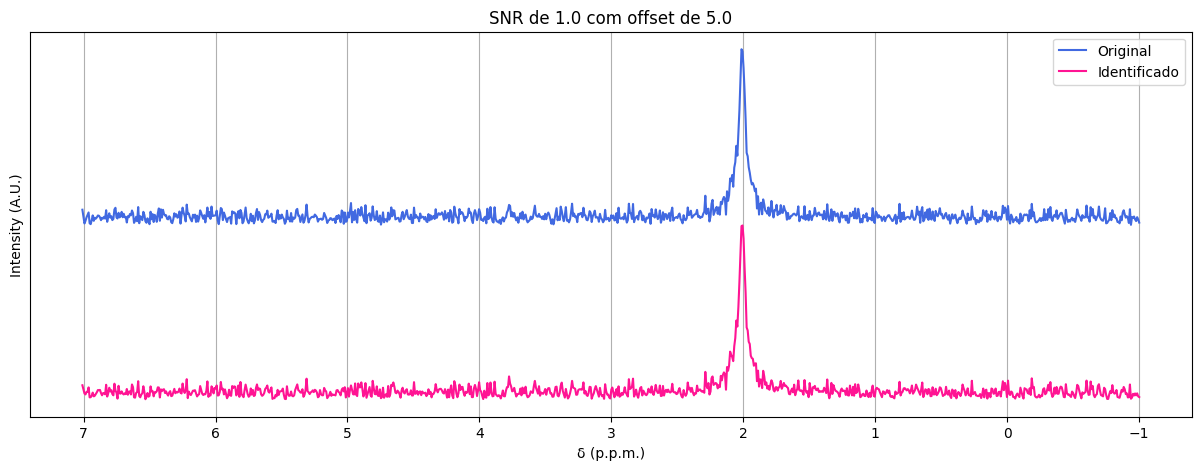

In [28]:
ws[1] = ws[0] + offsets[j]
print(ws)

_, c_sig_fft = pymri.fourier_spectrum(original_c_sigs[i, j, :], dt, B0)

y_offset = 1.0

plt.figure(figsize=(15, 5))
pymri.plot_chem_shifts(freqs, c_sig_fft, 1.0, y_offset=2*y_offset, label="Original", c = "royalblue")
pymri.plot_chem_shifts(freqs, identified_sig_fft, 1.0, y_offset=y_offset, label="Identificado", title=f"SNR de {sample_snrs[i]} com offset de {offsets[j]}")
plt.legend()
plt.yticks([])

In [ ]:
print(pymri.max_frequency(dt))

1024.0


Pelos resultados acima, parece ser possível concluir que a amplitude sozinha deixa de ser um bom parâmetro de filtro para dois picos com um grau significativo de sobreposição. É possível perceber que para SNRs mais altos, as duas frequências com maiores amplitudes são as frequências originais, enquanto abaixo de um certo valor de SNR isso deixa de ser verdade, até chegar em um ponto na qual nenhuma das duas frequências principais aparecem com as maiores amplitudes do sinal.

In [30]:
k = np.arange(0, L_, 1, dtype = int)

# plt.plot(k, avg_omega[:, 7])